Hunter Bennett | Glass Lab | Brain Aging Project | 19 Feb 2021

This notebook calls pairwise differential peaks using HOMER's getDiffExpression.pl wrapper of DESeq2. It then performes a number of steps to check and visualize this data.
1. report the genomic location of significant peaks in the UCSC browser format - use this to assess differential peak calling quality on the browser.
2. plot differential peaks as a scatter plot with significant peaks highlighted.
3. plot heatmap of tag counts at differential peaks.
4. write out differential peaks for analysis with GREAT
5. write differential peaks to bed files for visualization on UCSC browser.

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

### Set working directory

In [2]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/PU1/'
workingDirectory = '/home/h1bennet/brain_aging/results/00_PU1_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Read in raw peak files

In [3]:
if not os.path.isdir('4month_vs_25month'):
    os.mkdir('4month_vs_25month')
    
if not os.path.isdir('4month_vs_25month/figures'):
    os.mkdir('4month_vs_25month/figures')

### Select best samples
Based on the filtering performed in the unbiased clustering step

In [4]:
best_reps = ['03_mouse_BL6_M_9week_PU1_ChIP_H3K27ac_1_JOS_20190809_CTTGTA',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC',
       '07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_20191018_ACTTGA',
       '07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_2_JOS_20191018_AGTTCC',
       '07_mouse_BL6_M_31month_PU1_ChIP_H3K27ac_1_AL_20201111_GAACCGCG_TGACCTTA']

In [5]:
df, mat = read_annotated_peaks('./annotated_peaks/ann_raw_vw_peaks_merged.txt')
df.index.rename('PeakID', inplace=True)

# OPTIONAL: drop bad qc samples
# this is a dirty way of doing it but works fine
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df = df.loc[:, tst]
mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

df.to_csv('./4month_vs_25month/ann_raw_vw_peaks_merged_4month_vs_25month.txt', sep='\t')

Check that samples were filtered properly (this also helps when inputting the columns into getDiffExpression.pl

In [6]:
mat.columns.str.split('/').str[-1]

Index(['03_mouse_BL6_M_9week_PU1_ChIP_H3K27ac_1_JOS_20190809_CTTGTA',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC',
       '07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_20191018_ACTTGA',
       '07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_2_JOS_20191018_AGTTCC',
       '07_mouse_BL6_M_31month_PU1_ChIP_H3K27ac_1_AL_20201111_GAACCGCG_TGACCTTA'],
      dtype='object')

# Run differential peak analysis

In [7]:
%%bash
source activate deseq_36
getDiffExpression.pl ./4month_vs_25month/ann_raw_vw_peaks_merged_4month_vs_25month.txt \
00_pu1_4month 00_pu1_4month 00_pu1_4month 00_pu1_4month \
01_pu1_25month 01_pu1_25month 01_pu1_25month \
-peaks > ./4month_vs_25month/diff_vw_output.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_pu1_4month vs. 01_pu1_25month:
		Total Genes: 68001
		Total Up-regulated in 01_pu1_25month vs. 00_pu1_4month: 533 (0.784%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_pu1_25month vs. 00_pu1_4month: 166 (0.244%) [log2fold<-1, FDR<0.05]



### Read in peak files and drop samples that were not used in the differential analysis

In [8]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './4month_vs_25month/diff_vw_output.txt',
    './annotated_peaks/ann_norm_vw_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

# OPTIONAL: drop bad qc samples
tst = np.append(np.asarray([True]*18, 'bool'), peak_mat.columns.str.contains('|'.join(best_reps)))
peaks = peaks.loc[:, tst]
peak_mat = peak_mat.loc[:, peak_mat.columns.str.contains('|'.join(best_reps))]

# create dictionary of all comparisons (not really useful here since we are only doing one)
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (69421, 30)
getDiffExpression selected transcripts (68001, 28)
annotatePeaks selected peaks (68001, 30)


dict_keys(['00_pu1_4month vs. 01_pu1_25month'])

## Check that differential peaks look good on browser

In [9]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [11]:
diff_peak.sort_values('00_pu1_4month vs. 01_pu1_25month adj. p-value',
                      ascending=True).head(20)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_20191018_ACTTGA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_2_JOS_20191018_AGTTCC,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_31month_PU1_ChIP_H3K27ac_1_AL_20201111_GAACCGCG_TGACCTTA,00_pu1_4month vs. 01_pu1_25month Log2 Fold Change,00_pu1_4month vs. 01_pu1_25month p-value,00_pu1_4month vs. 01_pu1_25month adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr5-95939578-9,chr5,95933881,95950491,+,298.600006,./peak_files/03_mouse_BL6_M_9week_PU1_ChIP_H3K...,Intergenic,RLTR28|LTR|ERVL,-14753.0,NM_018866,...,7.951138,7.887120,7.665192,10.052959,10.356453,9.811713,2.678646,5.685528e-62,1.688090e-57,chr5:95933881-95950491
Merged-chr5-95898322-6,chr5,95894236,95902529,+,171.433334,./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_...,Intergenic,Intergenic,-58557.0,NM_018866,...,6.474807,6.612257,6.700027,8.605658,8.744640,8.359591,2.734974,4.689022e-41,6.961087e-37,chr5:95894236-95902529
Merged-chr5-95913340-4,chr5,95910476,95915606,+,142.000000,./peak_files/07_mouse_BL6_M_25month_PU1_ChIP_H...,Intergenic,Intergenic,-43898.0,NM_018866,...,5.664327,5.499489,5.673295,7.560780,7.950574,7.338679,3.451587,3.140993e-30,3.108640e-26,chr5:95910476-95915606
Merged-chr2-13786616-11,chr2,13781425,13794127,+,218.590912,./peak_files/03_mouse_BL6_M_9week_PU1_ChIP_H3K...,"intron (NM_145838, intron 2 of 7)","intron (NM_145838, intron 2 of 7)",5744.0,NM_145838,...,8.428770,8.162359,8.021011,9.463233,9.755388,9.443167,1.560928,1.007533e-23,5.982932e-20,chr2:13781425-13794127
Merged-chr19-29478459-3,chr19,29474679,29481275,+,205.166672,./peak_files/07_mouse_BL6_M_25month_PU1_ChIP_H...,Intergenic,IMPB_01|Satellite|Satellite,44010.0,NR_015567,...,5.533011,5.816397,5.856588,7.585072,8.223974,7.775674,3.234068,8.095641e-24,5.982932e-20,chr19:29474679-29481275
Merged-chr6-108659996-4,chr6,108658204,108661895,+,130.324997,./peak_files/07_mouse_BL6_M_25month_PU1_ChIP_H...,promoter-TSS (NM_011498),promoter-TSS (NM_011498),-580.0,NM_011498,...,5.626868,5.752748,5.656497,6.997790,7.657622,7.294398,2.979475,3.841659e-21,1.901045e-17,chr6:108658204-108661895
Merged-chr6-54728833-7,chr6,54726181,54733177,+,95.385712,./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_...,Intergenic,Intergenic,48055.0,NM_001289740,...,6.693233,6.615535,6.619051,8.137579,8.124491,7.934865,1.989230,1.010207e-20,4.054470e-17,chr6:54726181-54733177
Merged-chr5-139326563-10,chr5,139323365,139329034,+,164.639999,./peak_files/03_mouse_BL6_M_9week_PU1_ChIP_H3K...,promoter-TSS (NM_172723),promoter-TSS (NM_172723),-735.0,NM_172723,...,7.584604,7.713216,7.507273,8.654952,8.995180,8.841831,1.583798,1.092444e-20,4.054470e-17,chr5:139323365-139329034
Merged-chr17-5977750-10,chr17,5974764,5980733,+,142.910004,./peak_files/03_mouse_BL6_M_9week_PU1_ChIP_H3K...,"intron (NR_151772, intron 2 of 25)","intron (NR_151772, intron 2 of 25)",2162.0,NM_011523,...,7.387539,7.460680,6.917523,8.614523,8.822195,8.695103,1.796715,3.244480e-19,1.070354e-15,chr17:5974764-5980733


Drop location value once finished.

In [12]:
diff_peak = diff_peak.drop(columns='location')

# Create summary plots

In [13]:
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

Set parameters for creation of scatterplots - unfortunately this has to be done manually for each run of the analysis.

In [14]:
comps = ['00_pu1_4month vs. 01_pu1_25month']

groups = [[[0,1,2,3], [4,5,6]]]

cols = []
for i in groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    cols.append(subcols)
    
colors = [['#3182bd', '#de2d26']] * len(groups)

00_pu1_4month vs. 01_pu1_25month
N genes downregulated 166
N genes upregulated 533



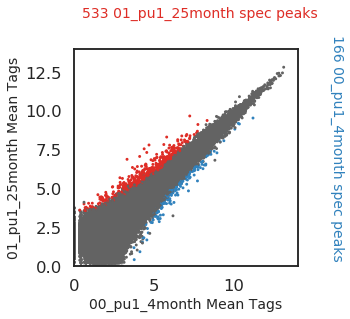

In [15]:
fc = np.log2(2)
pval = 0.05
textax = 16

for key, col, group, color in zip(comps, cols, groups, colors):
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#636363')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)))
    print('N genes upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > fc)))
    print('')

    fig, ax = plt.subplots(figsize=(4,4))
    # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=2, #de.log10p+0.05,
        c=dot_colors)

    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags', fontsize=14)
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags', fontsize=14)
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,textax,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc > fc)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(textax,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    # plt.close()

## Plot heatmap of differential peaks

1284


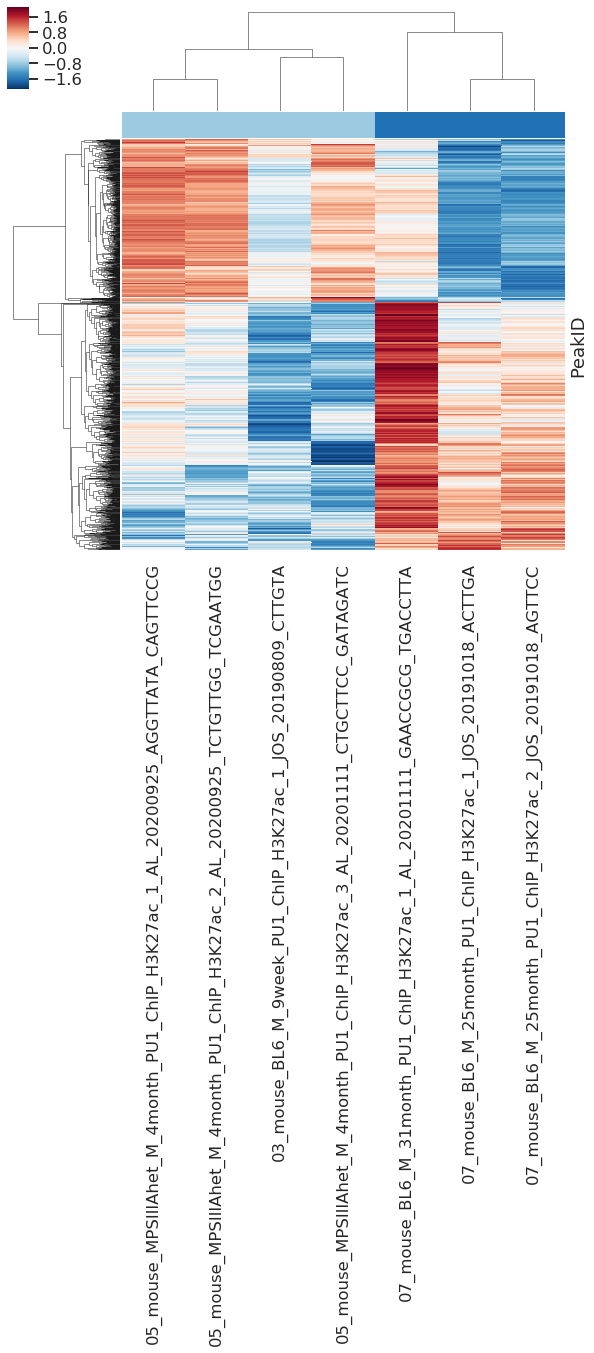

In [16]:
pval = 0.05
fc = np.log2(1.5)

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.loc[((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)), :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#9ecae1', '#9ecae1','#9ecae1', '#9ecae1',
                           '#2171b5','#2171b5', '#2171b5'],
               yticklabels=0,
               figsize=(10,10))
plt.savefig('./figures/diff_peaks_clustermap.png', bbox_inches='tight')

### Distal peaks only

1026


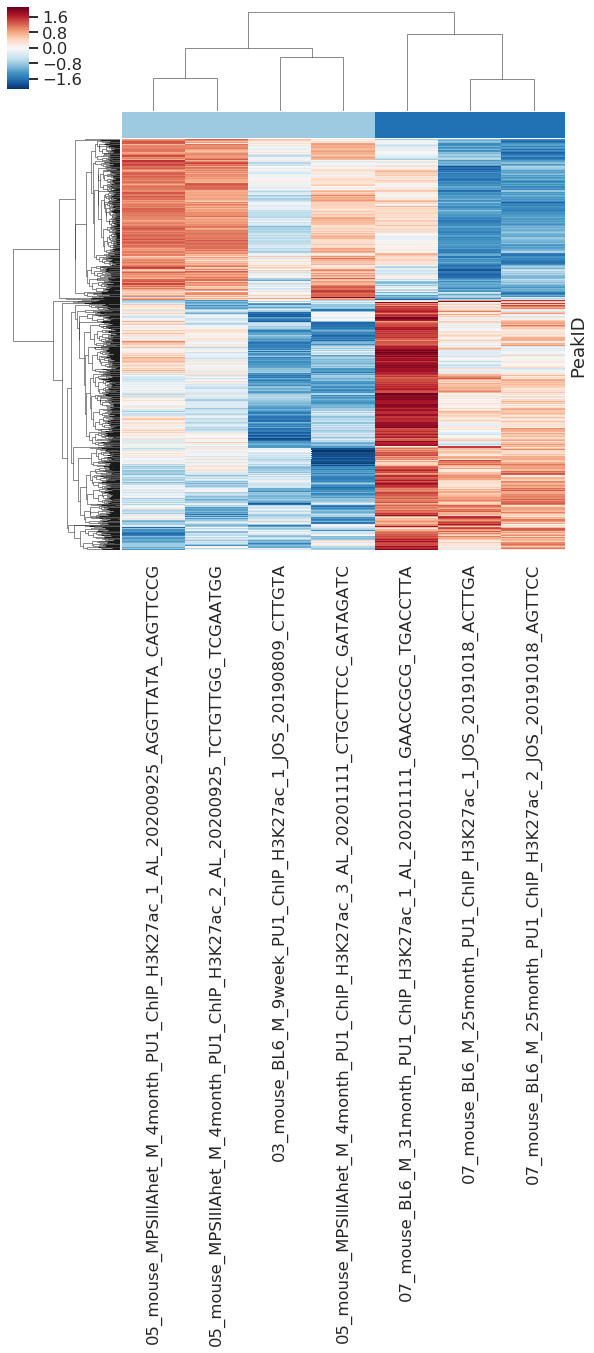

In [17]:
pval = 0.05
np.log2(1.5)

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)) & (np.abs(de.TSS_dist) >= 3000))
    sig_peaks_id.extend(de.loc[sig_peaks_bool, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#9ecae1', '#9ecae1','#9ecae1', '#9ecae1',
                           '#2171b5','#2171b5', '#2171b5'],
               yticklabels=0,
               figsize=(10,10))
plt.savefig('./figures/diff_peaks_distal_clustermap.png', bbox_inches='tight')

# Extract peaks for an analysis in GREAT
____
Next we will pull the peaks associated with each cell type and write them out. This section is particularly useful when doing multiple pairwise comparisons at once but it still works well here. This will also write out bed files which can be analyzed using the GREAT tool from Stanford.

To do this we end up resetting the diff_peak files because we end up adding columns to make the above plots and I'm lazy

In [25]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './4month_vs_25month/diff_vw_output.txt',
    './annotated_peaks/ann_raw_idr_vw_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

FileNotFoundError: [Errno 2] File b'./annotated_peaks/ann_raw_idr_vw_peaks_merged.txt' does not exist: b'./annotated_peaks/ann_raw_idr_vw_peaks_merged.txt'

In [26]:
# initialize dict and list of cell types
peak_lists = {}
cells = ['00_pu1_4month',
         '01_pu1_25month']

# set pvalue and fc thresholds
fc = np.log2(1.5)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing 00_pu1_4month ...

0
For comp: 00_pu1_4month vs. 01_pu1_25month
Union set at: 510 peaks
Intersection set at: 510 peaks

Analyzing 01_pu1_25month ...

0
For comp: 00_pu1_4month vs. 01_pu1_25month
Union set at: 774 peaks
Intersection set at: 774 peaks



### Save peak and bed files for GREAT analysis

In [27]:
if not os.path.isdir('./4month_vs_25month/great_analysis/'):
    os.mkdir('./4month_vs_25month/great_analysis/')
    
if not os.path.isdir('./4month_vs_25month/great_analysis/peak_files/'):
    os.mkdir('./4month_vs_25month/great_analysis/peak_files/')
    
if not os.path.isdir('./4month_vs_25month/great_analysis/bed_files/'):
    os.mkdir('./4month_vs_25month/great_analysis/bed_files/')

Save each set of peaks derived from the list - in this case its just one set activated in each group

In [28]:
for key in peak_lists.keys():
    # save cell specific promoters
    diff_peak.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4].to_csv(
        './4month_vs_25month/great_analysis/peak_files/'+key+'_act_peaks.txt',
        sep='\t')

Save full set of peaks for background

In [36]:
diff_peak.iloc[:, :4].to_csv(
    './4month_vs_25month/great_analysis/peak_files/pu1_all_peaks.txt',
    sep='\t')

Convert to bed files

In [37]:
%%bash
# delete the existing script file
rm ./peak_to_bed_great.sh
# create a script file
touch ./peak_to_bed_great.sh

In [38]:
%%bash
for peakfile in ./4month_vs_25month/great_analysis/peak_files/*txt;
do bedfile=${i/act/bg};
out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed_great.sh
done

# Create bed files for visualization in browser

In [39]:
if not os.path.isdir('./4month_vs_25month/bed_files/'):
    os.mkdir('./4month_vs_25month/bed_files/')

In [33]:
!cp ./4month_vs_25month/great_analysis/bed_files/*union* ./4month_vs_25month/bed_files/

In [34]:
!ls ./4month_vs_25month/bed_files/

00_pu1_4month_union_act_peaks.bed  01_pu1_25month_union_act_peaks.bed


Give track names for uploading to genome browser

In [41]:
%%bash

echo 'track name="PU1_H3K27Ac_4month_peaks" description="PU1 Nuclei 4month H3K27Ac Chip-seq DESeq2 specific peaks"' \
| cat - ./4month_vs_25month/bed_files/00_pu1_4month_union_act_peaks.bed \
> temp && mv temp ./4month_vs_25month/bed_files/00_pu1_4month_union_act_peaks.bed

echo 'track name="PU1_H3K27Ac_25month_peaks" description="PU1 Nuclei 25month H3K27Ac Chip-seq DESeq2 specific peaks"' \
| cat - ./4month_vs_25month/bed_files/01_pu1_25month_union_act_peaks.bed \
> temp && mv temp ./4month_vs_25month/bed_files/01_pu1_25month_union_act_peaks.bed